# Queue Modeling Analysis

### Simulation implementation of a grocery store.

A grocery store opens at 9 am and closes at 6 pm. There are several checkout queues, each with an assigned cashier, where shoppers wait for their turn to be served by a cashier.


The time between consecutive customers joining a queue is assumed to come from an exponential distribution with a rate parameter λ = 1 customer per minute. Customers enter the shortest queue when they have collected all their items and are ready to pay.


The time it takes for a cashier to serve a customer is normally distributed with mean µ1 = 3 minutes and a standard deviation σ 1 = 1 minute. 


After a shopper has been served, there is a slight chance (5%) they will need extended service from the store manager. The time taken for the manager to handle a request is also normally distributed but with mean µ2 = 4 minutes and a standard deviation σ2 = 1. There is only one manager and the manager can take only one customer at a time.


After closing time (6 pm), no one is allowed to join the queues anymore, and any customers already in the queues are served until no customers remain. Due to the physical constraints of the store, the number of queues/cashiers cannot exceed 10. 


How many cashiers should the grocery store employ? Address this staffing problem by implementing the simulation described above and analyzing relevant metrics.

In [13]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function,action_type, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.type=action_type
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function,action_type, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function,action_type, *args, **kwargs))
    
    def add_event_after(self, interval, function,action_type, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function,action_type, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp, self.priority_queue[0].type

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now}min ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'  ⏱ {event.timestamp}min: {event.function.__name__}')

In [14]:
import scipy.stats as sts
import random
from collections import deque
from matplotlib import pyplot as plt
import numpy as np


class Queue_MG1:
    '''
    Class implements the processes of adding customer
    to a specific queue, starting and finishing to serve a customer.
    
    '''
    
    def __init__(self, service_distribution, number, manager_queue):
        
        # Store the service time distribution for a queue
        self.service_distribution = service_distribution
        
        # Initialize the queue with an empty line and no one being served
        self.people_in_queue = 0
        self.people_being_served = 0
        
        #Initialize the queue number
        self.number=number
        
        #Create a reference to the manager queue
        self.manager_queue=manager_queue
        
        #Create variables to track queue length over time and waiting time
        self.queue_length_over_time=[]
        self.current_queue=deque([])
        self.waiting_time=[]

    def add_customer(self, schedule):
        '''
        Method is called on when a new customer is added to a queue.
        If the cashier is free, the customer is served right away.
        The number of people in queue and arrival time timestamp are recorded for further analysis.
        
        '''
        # Add the customer to the queue
        self.people_in_queue += 1
        
        #Record the queue length 
        self.queue_length_over_time.append(self.people_in_queue)
        
        #Start counting the waiting time of a customer
        self.current_queue.append(schedule.now)
        
        '''print(
            f'QUEUE {self.number}'
            f'⏱{schedule.now:5.2f}min: Add customer to queue.  '
            f' 🧍🏾‍♀️People in queue: {self.people_in_queue}')
        '''
        
        #if the cashier is free, serve the customer
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer,1)
            
    def start_serving_customer(self, schedule):
        '''
        Method is called when a cashier starts serving a customer.
        Method adds the end of service time to the scheduler
        and updates the number of people in the queue.
        '''
        
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        
        '''print(
            f'QUEUE {self.number}'
            f'⏱{schedule.now:5.2f}min: Start serving customer. '
            f' 🧍🏾‍♀️People in queue: {self.people_in_queue}')
        '''
        
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_customer, 2)
            
    def finish_serving_customer(self, schedule):
        '''
        Method is called when the cashier finishes serving a customer.
        Upon finishing service, it is randomly decided whether a customer will need manager help.
        If there are people in the queue, method to serve next customer is called.
        '''
        
        # Remove the customer from the server
        self.people_being_served -= 1
        
        #Calculate the final waiting time of the customer
        wait_time=schedule.now-self.current_queue.popleft()
        
        #Decide whether a customer needs manager's help
        #If so, the customer joins the manager queue
        if (np.random.random()<0.05):
            '''print(
                f'QUEUE {self.number}'
                f'⏱{ schedule.now:5.2f}min: Customer went to a manager.  '
                f' 🧍🏾‍♀️People in queue: {self.people_in_queue}')
            '''
            self.manager_queue.add_customer(schedule, wait_time)
        else:
            self.waiting_time.append(wait_time)
            '''print(
                f'QUEUE {self.number}'
                f'⏱{ schedule.now:5.2f}min: Stop serving customer.  '
                f' 🧍🏾‍♀️People in queue: {self.people_in_queue}')
            '''
        #If there are people in the queue, schedule serving the next customer
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer, 1)
    def queue_length(self):
        '''
        Method to return the number of people in the queue and
        number of people being served.
        '''
        return self.people_in_queue+self.people_being_served

class Manager_Queue:
    '''
    Separate class for a manager queue. 
    Functionality is similar to a usual queue.
    '''
    
    def __init__(self, service_distribution):
        
        #Define manager's service time distribution
        self.service_distribution=service_distribution
        
        #Create variables to store the number of people in the queue
        self.people_in_queue=0
        self.people_being_served=0
        
        #Create variables to store the waiting time of the customers
        self.waiting_time=[]
        self.current_queue=deque([])
    def add_customer(self, schedule, wait_time):
        '''
        Method is called on when a new customer is added to a manager queue.
        
        '''
        
        # Add the customer to the manager queue
        self.people_in_queue += 1
        '''print(
            f'MANAGER QUEUE'
            f'⏱{schedule.now:5.2f}min: Add customer to queue.  '
            f' 🧍🏾‍♀️People in queue: {self.people_in_queue}')
        '''
        #If the queue is empty, the customer can be served immediately
        if self.people_being_served < 1:
            schedule.add_event_after(0, self.start_serving_customer,1)
        
        #Record the time person started waiting and the time it took in the usual queue
        self.current_queue.append([wait_time, schedule.now])
            
    def start_serving_customer(self, schedule):
        '''
        Method is called when a manager starts serving a customer.
        Method adds the end of service time to the scheduler
        and updates the number of people in the queue.
        '''
        
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        '''print(
            f'MANAGER QUEUE'
            f'⏱{schedule.now:5.2f}min: Start serving customer. '
            f' 🧍🏾‍♀️People in queue: {self.people_in_queue}')
        '''
        # Schedule when the manager will be done with the customer
        schedule.add_event_after(
            self.service_distribution.rvs(),
            self.finish_serving_customer,2)
            
    def finish_serving_customer(self, schedule):
        '''
        Method is called when the manager finishes serving a customer.
        '''
        
        # Remove the customer from the manager queue
        self.people_being_served -= 1
        '''print(
            f'MANAGER QUEUE'
            f'⏱{ schedule.now:5.2f}min: Stop serving customer.  '
            f' 🧍🏾‍♀️People in queue: {self.people_in_queue}')
        '''
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer,1)
            
        #Record the total waiting time of the customer
        wait=self.current_queue.popleft()
        self.waiting_time.append(wait[0]+schedule.now-wait[1])
        

class GroceryStore_MG1:
    '''
    Class that implements the functionality of a grocery store
    with multiple queues and a separate manager queue.
    
    '''
    
    def __init__(self, arrival_distribution, service_distribution, number_of_queues, manager_service_distribution, run_until):
        
        #Define the manager queue as an instance of manager class
        self.manager_queue=Manager_Queue(manager_service_distribution)
        
        #Create a number of queues given in the parameter
        self.queues=[Queue_MG1(service_distribution, i, self.manager_queue) for i in range(number_of_queues)]
        
        #Define arrival distribution and end of working hours
        self.arrival_distribution = arrival_distribution
        self.run_until=run_until

    def add_customer(self, schedule):
        
        '''
        Method adds a customer to one of the queues, based on the shortest line length.
        
        '''
        
        #Find the queue lengths and place a customer to the shortest one
        fastest_queue=[self.queues[i].queue_length() for i in range(len(self.queues))]
        chosen=min(fastest_queue)
        index_of_chosen=fastest_queue.index(chosen)
        self.queues[index_of_chosen].add_customer(schedule)
        
        
        
        # If the store is open, schedule when to add another customer
        if schedule.now<=self.run_until:
            schedule.add_event_after(
                self.arrival_distribution.rvs(),
                self.add_customer, 0)

    def run(self, schedule):
        '''
        Methods starts grocery store's work.
        
        '''
        
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer, 0)
        

def run_simulation_MG1(arrival_distribution, service_distribution, run_until, number_of_queues, manager_service_distribution):
    '''
    Function to start the simulation with the given parameters:
    - Arrival distribution
    - Cashier service distribution
    - Work hours
    - Number of queues
    - Manager service distribution
    
    '''
    
    #Initialize schedule
    schedule = Schedule()
    
    #Create a grocery store with the given parameters
    grocery_store = GroceryStore_MG1(arrival_distribution, service_distribution, number_of_queues, manager_service_distribution, run_until)
    
    #Start the store's work
    grocery_store.run(schedule)

    #Execute actions while there are events in the schedule
    while len(schedule.priority_queue)>0:
        schedule.run_next_event()
    
    #Record and return the results of waiting time, queue length, and maximum queue length
    waiting_time_results=[]
    queue_length=[]
    
    for i in range(number_of_queues):
        waiting_time_results+=grocery_store.queues[i].waiting_time
        queue_length+=grocery_store.queues[i].queue_length_over_time
        
    return waiting_time_results+grocery_store.manager_queue.waiting_time, queue_length, max(queue_length)

In [15]:
#Initialize the variables

service_time_mean = 3
service_time_deviation=1
service_time_variance  = 1
lambda_value=1

# Arrival distribution is exponential with lambda = 1
arrival_distribution = sts.expon(scale=1/lambda_value)

# Service distribution is normal with mu = 3 and sigma = 1
service_distribution = sts.norm(loc=service_time_mean, scale=np.sqrt(service_time_variance))

#Manager service distribution is normal with mu=4 and sigma=1
manager_distribution=sts.norm(loc=4, scale=np.sqrt(1))

#Set up the duration of work
duration = 540 # in minutes

#initialize dictionaries to record data relevant to a number of cashiers
waiting_time={}
queue_length={}
maximum_queue={}


#Run the simulation 100 times for each value of number of cashiers
for i in range(1,11):
    for j in range(100):
        wait, queue, max_q = run_simulation_MG1(arrival_distribution, service_distribution, duration, i, manager_distribution)
        
        #Record the data
        if j==0:
            waiting_time[i]=wait
            queue_length[i]=queue
            maximum_queue[i]=[max_q]            
        else:
            waiting_time[i]+=wait
            queue_length[i]+=queue
            maximum_queue[i].append(max_q)

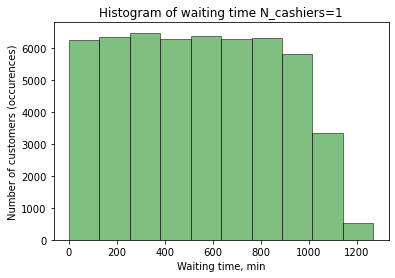

Mean of the waiting time for N_cashiers=1 is 544.01
Standard error of the mean: 1.36
95% confidence interval of population mean: [541.3444, 546.6756]


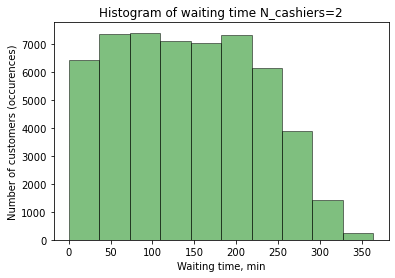

Mean of the waiting time for N_cashiers=2 is 142.62
Standard error of the mean: 0.36
95% confidence interval of population mean: [141.9144, 143.3256]


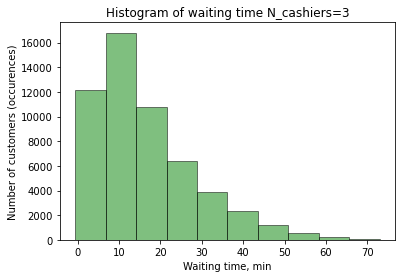

Mean of the waiting time for N_cashiers=3 is 16.47
Standard error of the mean: 0.05
95% confidence interval of population mean: [16.372, 16.567999999999998]


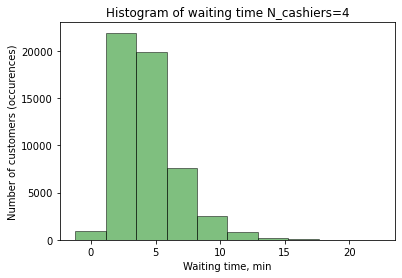

Mean of the waiting time for N_cashiers=4 is 4.38
Standard error of the mean: 0.01
95% confidence interval of population mean: [4.3604, 4.3995999999999995]


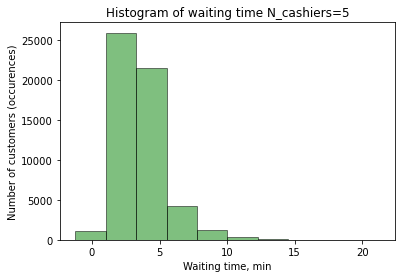

Mean of the waiting time for N_cashiers=5 is 3.58
Standard error of the mean: 0.01
95% confidence interval of population mean: [3.5604, 3.5996]


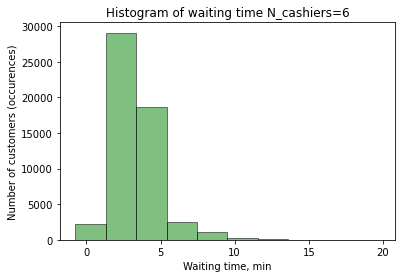

Mean of the waiting time for N_cashiers=6 is 3.35
Standard error of the mean: 0.01
95% confidence interval of population mean: [3.3304, 3.3696]


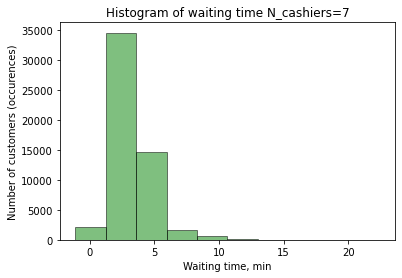

Mean of the waiting time for N_cashiers=7 is 3.27
Standard error of the mean: 0.01
95% confidence interval of population mean: [3.2504, 3.2896]


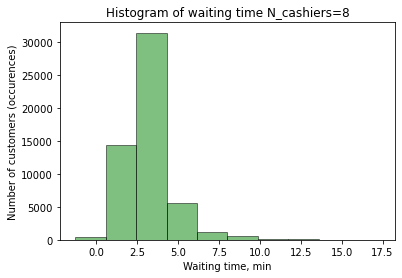

Mean of the waiting time for N_cashiers=8 is 3.24
Standard error of the mean: 0.01
95% confidence interval of population mean: [3.2204, 3.2596000000000003]


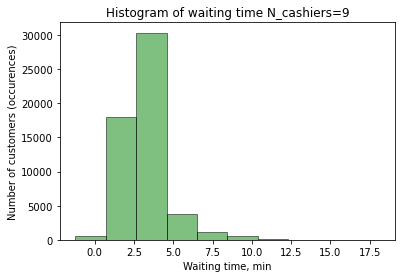

Mean of the waiting time for N_cashiers=9 is 3.23
Standard error of the mean: 0.01
95% confidence interval of population mean: [3.2104, 3.2496]


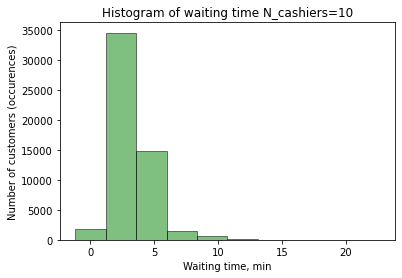

Mean of the waiting time for N_cashiers=10 is 3.23
Standard error of the mean: 0.01
95% confidence interval of population mean: [3.2104, 3.2496]


In [16]:
#Waiting time histograms + mean + 95% confidence interval
for i in range(1,11):
    
    #Plot the histogram
    plt.figure()
    plt.hist(waiting_time[i],color='green', bins=10,alpha=0.5, histtype='bar', ec='black')
    plt.xlabel("Waiting time, min")
    plt.ylabel("Number of customers (occurences)")
    plt.title(f'Histogram of waiting time N_cashiers={i}')
    plt.show()
    
    #Calculate and display the mean
    m_approx = round(np.mean(waiting_time[i]), 2)
    print(f'Mean of the waiting time for N_cashiers={i} is {m_approx}')

    #Calculate the display SE of the mean
    t = sts.sem(waiting_time[i])
    t_approx = round(t, 2)
    print('Standard error of the mean:', t_approx)
    
    #Calculate and display the 95% confindence interval of population mean
    lower_bound=m_approx - 1.96*t_approx
    upper_bound=m_approx + 1.96*t_approx
    print('95% confidence interval of population mean:', [lower_bound,upper_bound])

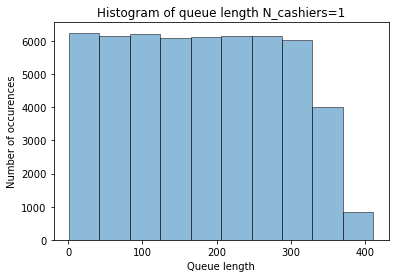

Mean of the queue length for N_cashiers=1 is 180.66
Standard error of the mean: 0.45
95% confidence interval of population mean: [179.778, 181.542]


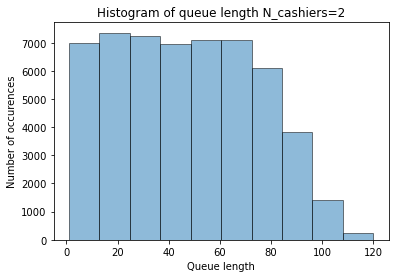

Mean of the queue length for N_cashiers=2 is 46.89
Standard error of the mean: 0.12
95% confidence interval of population mean: [46.6548, 47.1252]


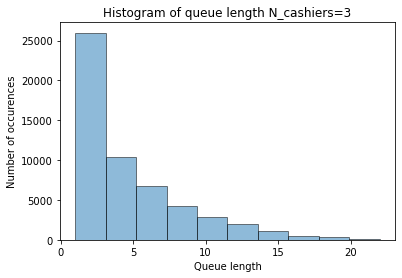

Mean of the queue length for N_cashiers=3 is 4.79
Standard error of the mean: 0.02
95% confidence interval of population mean: [4.7508, 4.8292]


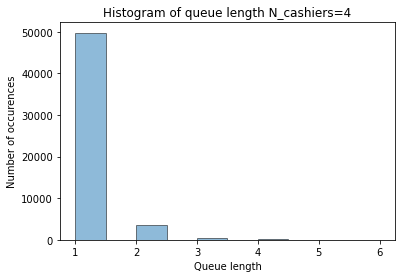

Mean of the queue length for N_cashiers=4 is 1.09
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.09, 1.09]


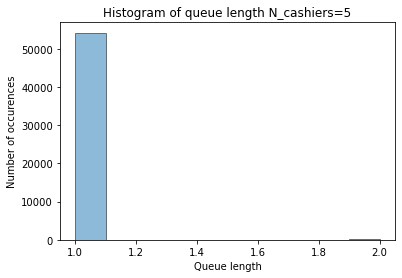

Mean of the queue length for N_cashiers=5 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


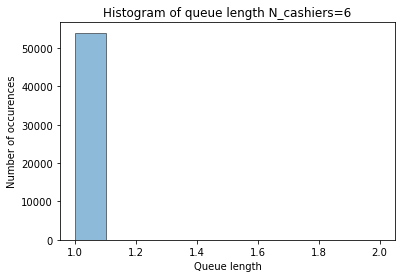

Mean of the queue length for N_cashiers=6 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


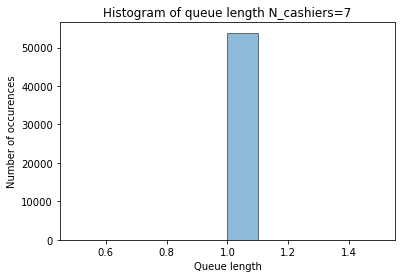

Mean of the queue length for N_cashiers=7 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


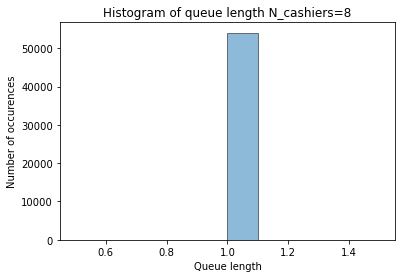

Mean of the queue length for N_cashiers=8 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


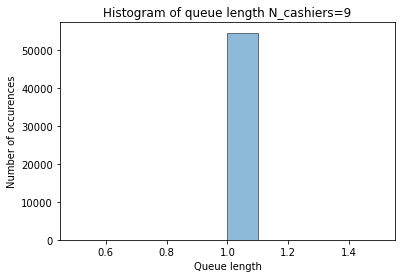

Mean of the queue length for N_cashiers=9 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


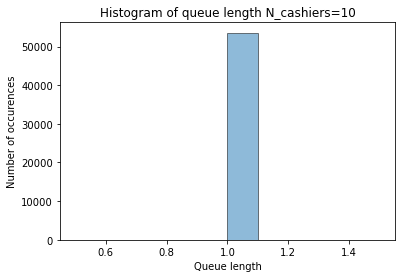

Mean of the queue length for N_cashiers=10 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


In [17]:
#Queue length histogram + mean + 95% confiendence interval
for i in range(1,11):
    #Plot the histogram
    plt.figure()
    plt.hist(queue_length[i], bins=10,alpha=0.5, histtype='bar', ec='black')
    plt.xlabel("Queue length")
    plt.ylabel("Number of occurences")
    plt.title(f'Histogram of queue length N_cashiers={i}')
    plt.show()
    
    #Calculate and display the mean
    m_approx = round(np.mean(queue_length[i]), 2)
    print(f'Mean of the queue length for N_cashiers={i} is {m_approx}')

    #Calculate the display SE of the mean
    t = sts.sem(queue_length[i])
    t_approx = round(t, 2)
    print('Standard error of the mean:', t_approx)
    
    #Calculate and display the 95% confindence interval of population mean
    lower_bound=m_approx - 1.96*t_approx
    upper_bound=m_approx + 1.96*t_approx
    print('95% confidence interval of population mean:', [lower_bound,upper_bound])

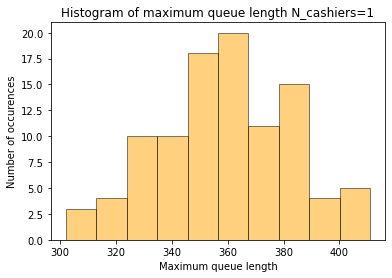

Mean of the maximum queue length for N_cashiers=1 is 359.52
Standard error of the mean: 2.42
95% confidence interval of population mean: [354.7768, 364.2632]


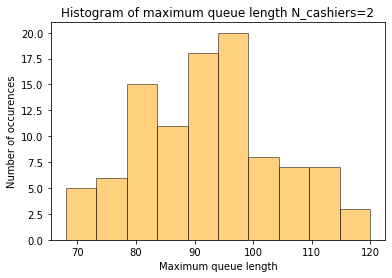

Mean of the maximum queue length for N_cashiers=2 is 92.62
Standard error of the mean: 1.18
95% confidence interval of population mean: [90.30720000000001, 94.9328]


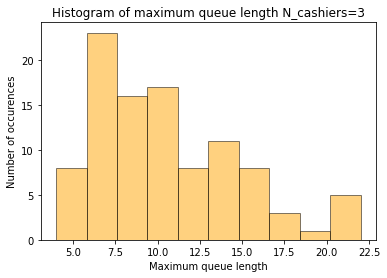

Mean of the maximum queue length for N_cashiers=3 is 10.41
Standard error of the mean: 0.43
95% confidence interval of population mean: [9.5672, 11.2528]


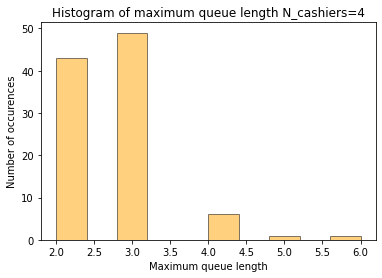

Mean of the maximum queue length for N_cashiers=4 is 2.68
Standard error of the mean: 0.07
95% confidence interval of population mean: [2.5428, 2.8172]


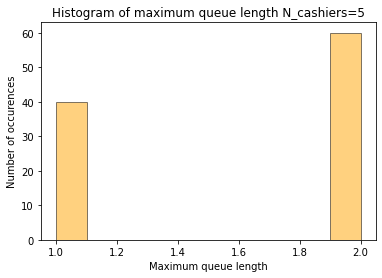

Mean of the maximum queue length for N_cashiers=5 is 1.6
Standard error of the mean: 0.05
95% confidence interval of population mean: [1.502, 1.6980000000000002]


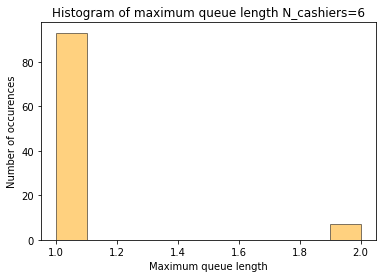

Mean of the maximum queue length for N_cashiers=6 is 1.07
Standard error of the mean: 0.03
95% confidence interval of population mean: [1.0112, 1.1288]


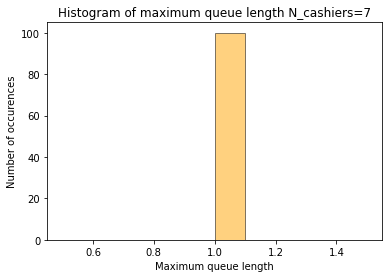

Mean of the maximum queue length for N_cashiers=7 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


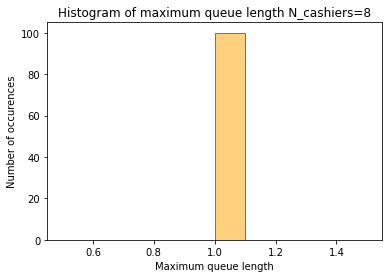

Mean of the maximum queue length for N_cashiers=8 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


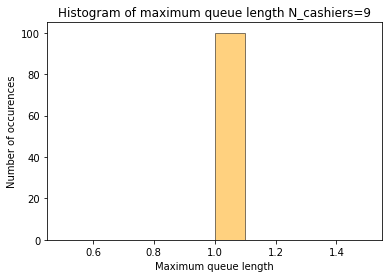

Mean of the maximum queue length for N_cashiers=9 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


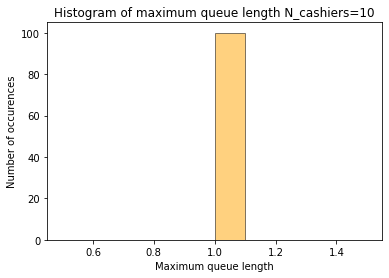

Mean of the maximum queue length for N_cashiers=10 is 1.0
Standard error of the mean: 0.0
95% confidence interval of population mean: [1.0, 1.0]


In [18]:
#Maximum queue length histogram + mean + 95% confiendence interval
for i in range(1,11):
    
    #Plot the histogram
    plt.figure()
    plt.hist(maximum_queue[i], bins=10,color='orange',alpha=0.5, histtype='bar', ec='black')
    plt.xlabel("Maximum queue length")
    plt.ylabel("Number of occurences")
    plt.title(f'Histogram of maximum queue length N_cashiers={i}')
    plt.show()
    
    #Calculate and display the mean
    m_approx = round(np.mean(maximum_queue[i]), 2)
    print(f'Mean of the maximum queue length for N_cashiers={i} is {m_approx}')

    #Calculate the display SE of the mean
    t = sts.sem(maximum_queue[i])
    t_approx = round(t, 2)
    print('Standard error of the mean:', t_approx)
    
    #Calculate and display the 95% confindence interval of population mean
    lower_bound=m_approx - 1.96*t_approx
    upper_bound=m_approx + 1.96*t_approx
    print('95% confidence interval of population mean:', [lower_bound,upper_bound])